# CUDA-MODE session 4 (ch 4 + 5 of the book)

Notebook by Thomas Viehmann, based on Jeremy Howard's notebook from lecture 3

# lecture 4 notes:

## more on SM architecture

each thread has its resources, meaning they can be accessed directly, whilst using the shared resouces requires special decleration:

exmaple: 
```
__global__ void exampleKernel(float *input, float *output, int N) {
    // Declare a shared memory array
    __shared__ float shared_data[256];
    
    int idx = threadIdx.x + blockIdx.x * blockDim.x; // Calculate global index for each thread

    // Load input data into a register (fastest memory for each thread)
    float temp = (idx < N) ? input[idx] : 0.0f;  // 'temp' is a register variable
```


**the program counter**:
keeps track of which command being executed, ie to which sub modules to route the input. 
if the program has no ifs, so all thread sfollow the same path. 
if there is an if, than depending on the input, the program follows different paths. 
in such a case either each thread needs it's own counter, or the global counter freezes one set of thread, executes path a, and then does the other, therefore **if clauses make the program run longer**. 

**int 64** has limited dedicated cores, so best to avoid. 

wraps:
a wrap is a group of up to 32 threads executing together within an sm. **wraps run 'effectively in parallel'**. technichally each resource on the sm can only be used by one wrap at a time, but whenever a wrap is waiting for some dependency, the scheduler can issue commands to another 'residant' wrap to use the currently available modules.

efficiency:
exmaple:
```
def gelu(x):
    return 0.5 * x * (1+ torch.tanh((2/torch.pi)**0.5 * (x+0.044715 * x**3)))

x = torch.randn(1024, 1024, device="cuda")
```

each op, is a seperate kernel:
1. launch, compute, save x**3
2. launch, compute, save x+0.044715
3. launch, compute, save  (x+0.044715 * x**3)
4. ...
5. return
therefore, the vanilla pytorch took 8 times longer than than the actual pytorch. 
but if we combine them all in single kernel, the time is the same as the torch function:
``` cuda_src = cuda_begin + r
__global__ void my_gelu_kernel(float* out, float* inp, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i >= n) return;
    float x = inp[i];
    out[i] = 0.5f * x * (1.0f+ tanhf(sqrtf(2.0f/3.141592653589793f) * (x+0.044715f * (x*x*x))));
}
```

and can split the ooutput to a seperate kernel to highlight time of computaiton
```
torch::Tensor my_gelu_out(torch::Tensor output, const torch::Tensor& inp) {
    CHECK_INPUT(inp);
    int n = inp.numel();
    TORCH_CHECK((output.sizes() == inp.sizes())  || (output.device() == inp.device())
                || (output.scalar_type() == inp.scalar_type()));
    int threads = 256;
    my_gelu_kernel<<<cdiv(n, threads), threads>>>(
        output.data_ptr<float>(), inp.data_ptr<float>(), n);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

torch::Tensor my_gelu(const torch::Tensor& inp) {
    CHECK_INPUT(inp);
    auto output = torch::empty_like(inp);
    my_gelu_out(output, inp);
    return output;
}
'''

cpp_src = """
torch::Tensor my_gelu(const torch::Tensor& inp);
torch::Tensor my_gelu_out(torch::Tensor output, const torch::Tensor& inp);
"""


## cuda working:
'numerical precision': 
- FP32: Typically around 10⁻⁷ or 10⁻⁸.
- FP64: Higher precision.

## memory types:
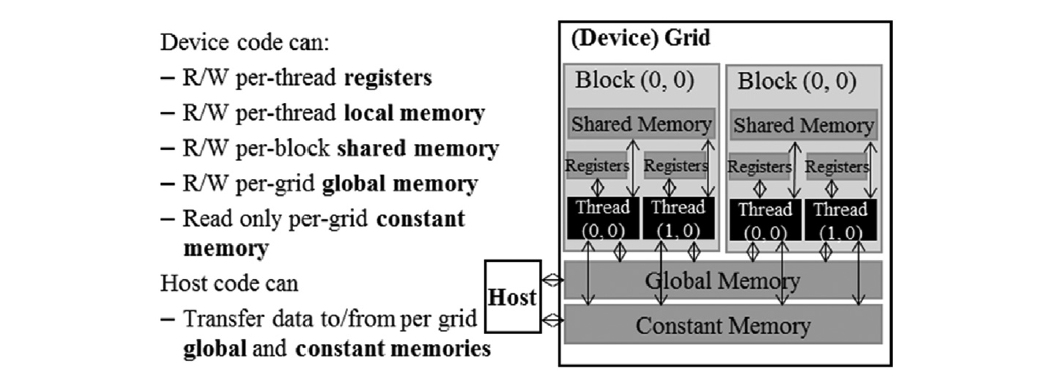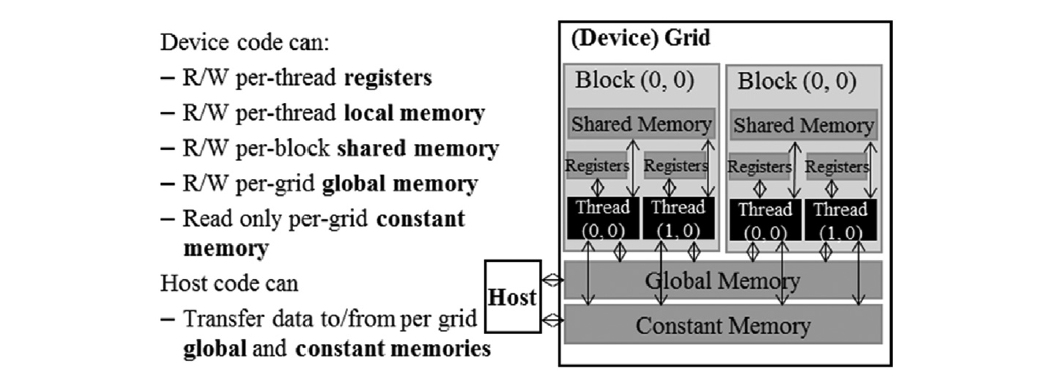

| Variable Declaration                     | Memory     | Scope    | Lifetime     |
|------------------------------------------|------------|----------|--------------|
| Automatic variables other than arrays    | Register   | Thread   | Grid         |
| Automatic array variables                | Local      | Thread   | Grid         |
| `__device__ __shared__ int SharedVar;`   | Shared     | Block    | Grid         |
| `__device__ int GlobalVar;`              | Global     | Grid     | Application  |
| `__device__ __constant__ int ConstVar;`  | Constant   | Grid     | Application  |



- Registers: Fastest, used for local variables within a thread.
- Local Memory: Slower than registers, used for arrays declared within a thread or for register spills.
- Shared Memory: Per-block memory, faster than global memory, accessible by all threads in a block, declared using   -`___shared__.`
- Global Memory: Main GPU memory, accessible by all threads, typically accessed through pointers.
- Constant Memory: Read-only memory, cached, used for kernel launch parameters and can be explicitly declared.

# tiling - see lecture 5

In [ ]:
!pip install ninja
!sudo apt update
!sudo apt install g++-11 -y
!sudo apt install ccache -y

In [17]:
import torch
import torch.utils.cpp_extension
import os
os.environ['CXX'] = '/usr/lib/ccache/g++-11'
os.environ['CC'] = '/usr/lib/ccache/gcc-11'

In [2]:

# based on Jeremy's Lecture 3 notebook
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* out, unsigned char* in, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i >= n) return;
    out[i] = 0.2989f*in[i] + 0.5870f*in[i+n] + 0.1140f*in[i+2*n];  // fix with f found by Andreas...
}

torch::Tensor rgb_to_grayscale_out(torch::Tensor output, const torch::Tensor& input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    TORCH_CHECK((h == output.size(0)) || (w == output.size(1)) || (output.device() == input.device())
                || (output.scalar_type() == input.scalar_type()));
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        output.data_ptr<unsigned char>(), input.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

torch::Tensor rgb_to_grayscale(const torch::Tensor& input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    auto output = torch::empty({h,w}, input.options());
    rgb_to_grayscale_out(output, input);
    return output;
}
'''

cpp_src = """
torch::Tensor rgb_to_grayscale(const torch::Tensor& input);
torch::Tensor rgb_to_grayscale_out(torch::Tensor outpuit, const torch::Tensor& input);
"""

import os
os.environ['CXX'] = '/usr/lib/ccache/g++-11'
os.environ['CC'] = '/usr/lib/ccache/gcc-11'

module = torch.utils.cpp_extension.load_inline(
    "test_ext", cpp_src, cuda_src, 
    functions=['rgb_to_grayscale', 'rgb_to_grayscale_out'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True)



n = 2048
t = torch.randint(0, 256, (3, n, n), dtype=torch.uint8, device="cuda")
out = module.rgb_to_grayscale(t); torch.cuda.synchronize()

import time
t0 = time.perf_counter_ns()
for i in range(10_000):
    module.rgb_to_grayscale_out(out, t)
torch.cuda.synchronize()
t1 = time.perf_counter_ns()

print((t1-t0) / 10_000 / 1_000, "µs") 


with torch.profiler.profile() as prof:
    for i in range(10_000):
        module.rgb_to_grayscale_out(out, t)
        torch.cuda.synchronize()

print(prof.key_averages().table())


Using /home/tv/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/tv/.cache/torch_extensions/py310_cu121/test_ext/build.ninja...
Building extension module test_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/lib/ccache/g++-11 -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=test_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/tv/.cache/torch_extensions/py310_cu121/test_ext/main.cpp -o main.o 
[2/3] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -ccbin /usr/lib/ccache/gcc-11 -DTORCH_EXTENSION_NAME=test_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-packages/torch/inclu

Loading extension module test_ext...


26.8034565 µs


STAGE:2024-02-03 18:46:05 288753:288753 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-02-03 18:46:05 288753:288753 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-03 18:46:05 288753:288753 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        12.93%      32.585ms        12.93%      32.585ms       3.259us       0.000us         0.00%       0.000us       0.000us         10000  
rgb_to_grayscale_kernel(unsigned char*, unsigned cha...         0.00%       0.000us         0.00%       0.000us       0.000us     269.413ms       100.00%     269.413ms      26.941us         10000  
         

# Approximate gelu as a fusion example

In [3]:
# as per the pytorch doc, implemented manually
def gelu(x):
    return 0.5 * x * (1+ torch.tanh((2/torch.pi)**0.5 * (x+0.044715 * x**3)))

x = torch.randn(1024, 1024, device="cuda")

In [4]:
gelu(x) - torch.nn.functional.gelu(x, approximate='tanh')

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [5]:
%timeit gelu(x); torch.cuda.synchronize()
%timeit torch.nn.functional.gelu(x, approximate='tanh'); torch.cuda.synchronize()

435 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
61.6 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Kind of slow. Why?

In [6]:
cuda_src = cuda_begin + r'''
__global__ void my_gelu_kernel(float* out, float* inp, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i >= n) return;
    float x = inp[i];
    out[i] = 0.5f * x * (1.0f+ tanhf(sqrtf(2.0f/3.141592653589793f) * (x+0.044715f * (x*x*x))));
}

torch::Tensor my_gelu_out(torch::Tensor output, const torch::Tensor& inp) {
    CHECK_INPUT(inp);
    int n = inp.numel();
    TORCH_CHECK((output.sizes() == inp.sizes())  || (output.device() == inp.device())
                || (output.scalar_type() == inp.scalar_type()));
    int threads = 256;
    my_gelu_kernel<<<cdiv(n, threads), threads>>>(
        output.data_ptr<float>(), inp.data_ptr<float>(), n);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

torch::Tensor my_gelu(const torch::Tensor& inp) {
    CHECK_INPUT(inp);
    auto output = torch::empty_like(inp);
    my_gelu_out(output, inp);
    return output;
}
'''

cpp_src = """
torch::Tensor my_gelu(const torch::Tensor& inp);
torch::Tensor my_gelu_out(torch::Tensor output, const torch::Tensor& inp);
"""

import os
os.environ['CXX'] = '/usr/lib/ccache/g++-11'
os.environ['CC'] = '/usr/lib/ccache/gcc-11'

gelu_module = torch.utils.cpp_extension.load_inline(
    "test_ext_gelu", cpp_src, cuda_src, 
    functions=['my_gelu', 'my_gelu_out'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True)

Using /home/tv/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/tv/.cache/torch_extensions/py310_cu121/test_ext_gelu/build.ninja...
Building extension module test_ext_gelu...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/lib/ccache/g++-11 -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=test_ext_gelu -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/tv/.cache/torch_extensions/py310_cu121/test_ext_gelu/main.cpp -o main.o 
[2/3] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -ccbin /usr/lib/ccache/gcc-11 -DTORCH_EXTENSION_NAME=test_ext_gelu -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-packa

Loading extension module test_ext_gelu...


In [7]:
(gelu_module.my_gelu(x) - gelu(x)).abs().max()

tensor(2.3842e-07, device='cuda:0')

In [8]:
%timeit gelu_module.my_gelu(x); torch.cuda.synchronize()

55.9 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Empty kernel to measure launch latency


In [9]:
cuda_src = cuda_begin + r'''
__global__ void my_empty_kernel(float* out, float* inp, int n) {
}

torch::Tensor my_empty_out(torch::Tensor output, const torch::Tensor& inp) {
    CHECK_INPUT(inp);
    int n = inp.numel();
    TORCH_CHECK((output.sizes() == inp.sizes())  || (output.device() == inp.device())
                || (output.scalar_type() == inp.scalar_type()));
    int threads = 256;
    my_empty_kernel<<<cdiv(n, threads), threads>>>(
        output.data_ptr<float>(), inp.data_ptr<float>(), n);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

torch::Tensor my_empty(const torch::Tensor& inp) {
    CHECK_INPUT(inp);
    auto output = torch::empty_like(inp);
    my_empty_out(output, inp);
    return output;
}
'''

cpp_src = """
torch::Tensor my_empty(const torch::Tensor& inp);
torch::Tensor my_empty_out(torch::Tensor output, const torch::Tensor& inp);
"""

import os
os.environ['CXX'] = '/usr/lib/ccache/g++-11'
os.environ['CC'] = '/usr/lib/ccache/gcc-11'

empty_module = torch.utils.cpp_extension.load_inline(
    "test_ext_empty", cpp_src, cuda_src, 
    functions=['my_empty', 'my_empty_out'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True)

Using /home/tv/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/tv/.cache/torch_extensions/py310_cu121/test_ext_empty/build.ninja...
Building extension module test_ext_empty...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/lib/ccache/g++-11 -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=test_ext_empty -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/tv/.cache/torch_extensions/py310_cu121/test_ext_empty/main.cpp -o main.o 
[2/3] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -ccbin /usr/lib/ccache/gcc-11 -DTORCH_EXTENSION_NAME=test_ext_empty -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-pa

Loading extension module test_ext_empty...


In [10]:
%timeit empty_module.my_empty_out(x, x); torch.cuda.synchronize()

with torch.profiler.profile() as prof:
    for i in range(10_000):
        empty_module.my_empty_out(x, x)
        torch.cuda.synchronize()
print(prof.key_averages().table())

15.6 µs ± 261 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


STAGE:2024-02-03 18:47:47 288753:288753 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-02-03 18:47:47 288753:288753 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-03 18:47:47 288753:288753 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                        cudaLaunchKernel        80.81%      42.183ms        80.81%      42.183ms       4.218us       0.000us         0.00%       0.000us       0.000us         10000  
    my_empty_kernel(float*, float*, int)         0.00%       0.000us         0.00%       0.000us       0.000us      30.000ms       100.00%      30.000ms       3.000us         10000  
                   cudaDeviceSynchronize        19.19%      10.020ms        19.19%  

In [11]:
## Matmul

In [12]:
cuda_src = cuda_begin + r'''
__global__ void simple_matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor simple_matmul(const torch::Tensor& m, const torch::Tensor& n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    simple_matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

cpp_src = """
torch::Tensor simple_matmul(const torch::Tensor& m, const torch::Tensor& n);
"""

simple_matmul_module = torch.utils.cpp_extension.load_inline(
    "test_ext_simple_matmul", cpp_src, cuda_src, 
    functions=['simple_matmul'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True)

Using /home/tv/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/tv/.cache/torch_extensions/py310_cu121/test_ext_simple_matmul/build.ninja...
Building extension module test_ext_simple_matmul...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module test_ext_simple_matmul...


In [13]:
a = torch.randn(1024, 1024, device="cuda")
b = torch.randn(1024, 1024, device="cuda")
%timeit simple_matmul_module.simple_matmul(a, b)

(simple_matmul_module.simple_matmul(a, b) - a@b).abs().max()

934 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


tensor(0.0002, device='cuda:0')

## Tiled matmul

In [14]:
cuda_src = cuda_begin + r"""
constexpr int TILE_SIZE = 16;

__global__ void tiled_matmul_kernel(float* out, float* M, float* N, int h, int w, int k) {
  __shared__ float M_tile[TILE_SIZE][TILE_SIZE];
  __shared__ float N_tile[TILE_SIZE][TILE_SIZE];
  
  // idxes into tile
  int ir = threadIdx.y;
  int ic = threadIdx.x;
  
  int r = blockIdx.y * blockDim.y + threadIdx.y;
  int c = blockIdx.x * blockDim.x + threadIdx.x;

  // note: cannot just exit if we want to do padding!
  
  float res = 0.0f;
  for (int K_tileidx = 0; K_tileidx < (k + TILE_SIZE -1) / TILE_SIZE; K_tileidx++) {
    // note how threadIdx.x is the fastes moving bit --> coalesced memory access
    M_tile[ir][ic] = (((r < h) && (K_tileidx * TILE_SIZE + ic < k)) ? M[r * k + K_tileidx * TILE_SIZE + ic] : 0.f);
    N_tile[ir][ic] = ((((K_tileidx * TILE_SIZE + ir) < k) && (c < w)) ? N[(K_tileidx * TILE_SIZE + ir) * w + c] : 0.f);
    //M_tile[ir][ic] = M[r * k + K_tileidx * TILE_SIZE + ic];
    //N_tile[ir][ic] = N[(K_tileidx * TILE_SIZE + ir) * w + c];
    __syncthreads();
    for (int idx = 0; idx < TILE_SIZE; idx++) {
       res += M_tile[ir][idx] * N_tile[idx][ic];
    }
    __syncthreads(); // important! (why?)
  }
  if ((r < h) && (c < w)) {
    out[r * w + c] = res;
  }
}

torch::Tensor tiled_matmul(const torch::Tensor& m, const torch::Tensor& n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch");
    //TORCH_CHECK((k % TILE_SIZE == 0) && (h % TILE_SIZE == 0) && (w % TILE_SIZE == 0), "Padding not done");
    auto output = torch::empty({h, w}, m.options());

    dim3 tpb(TILE_SIZE, TILE_SIZE);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    tiled_matmul_kernel<<<blocks, tpb>>>(
        output.data_ptr<float>(), m.data_ptr<float>(), n.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

"""
cpp_src = """
torch::Tensor tiled_matmul(const torch::Tensor& m, const torch::Tensor& n);
"""

tiled_matmul_module = torch.utils.cpp_extension.load_inline(
    "test_ext_tiled_matmul", cpp_src, cuda_src, 
    functions=['tiled_matmul'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True)

Using /home/tv/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/tv/.cache/torch_extensions/py310_cu121/test_ext_tiled_matmul/build.ninja...
Building extension module test_ext_tiled_matmul...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/lib/ccache/g++-11 -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=test_ext_tiled_matmul -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/tv/.cache/torch_extensions/py310_cu121/test_ext_tiled_matmul/main.cpp -o main.o 
[2/3] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -ccbin /usr/lib/ccache/gcc-11 -DTORCH_EXTENSION_NAME=test_ext_tiled_matmul -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /usr/local/l

Loading extension module test_ext_tiled_matmul...


In [15]:
%timeit tiled_matmul_module.tiled_matmul(a, b)

707 µs ± 6.36 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
aa = torch.randn(500, 200, device="cuda")
bb = torch.randn(200, 1000, device="cuda")


(tiled_matmul_module.tiled_matmul(aa, bb) - aa@bb).abs().max()


tensor(4.5776e-05, device='cuda:0')

# Occupancy?

- shared memory: 64k/2k -> 32
- threads: 1536/256 -> 6

$\rightarrow$ we could afford larger tiles